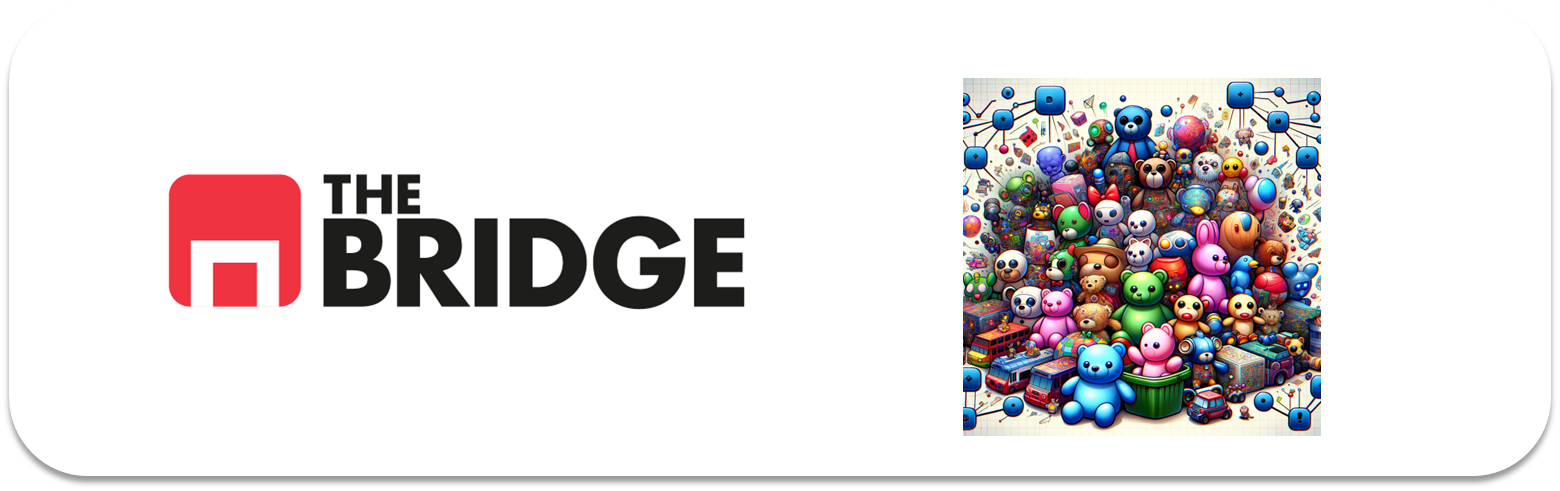

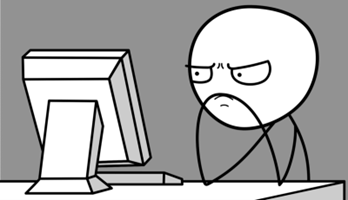

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [2]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns


from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [5]:
df = pd.read_csv("./data/empowering_drinks.csv", sep = "|")
df.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,14.02,2.21,2.33,1035,4.70
1,11.56,3.23,5.08,465,6.00
2,12.58,2.10,0.58,640,7.60
3,12.33,2.28,1.09,680,3.27
4,12.37,1.36,0.57,520,1.95


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               157 non-null    float64
 1   Vitamínas del grupo B  157 non-null    float64
 2   Cafeína                157 non-null    float64
 3   Ácido Cítrico          157 non-null    int64  
 4   Taurina                157 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 6.3 KB


In [7]:
df.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,157.000000,157.000000,157.000000,157.000000,157.000000
mean,12.996815,2.368917,2.088790,763.089172,4.873694
std,0.845703,0.267394,1.027656,321.352179,2.151649
min,11.030000,1.360000,0.340000,290.000000,1.280000
25%,12.290000,2.220000,1.090000,502.000000,3.050000
50%,13.050000,2.360000,2.250000,680.000000,4.600000
75%,13.710000,2.560000,2.920000,1020.000000,6.100000
max,14.830000,3.230000,5.080000,1680.000000,10.680000


In [10]:
train_set = df

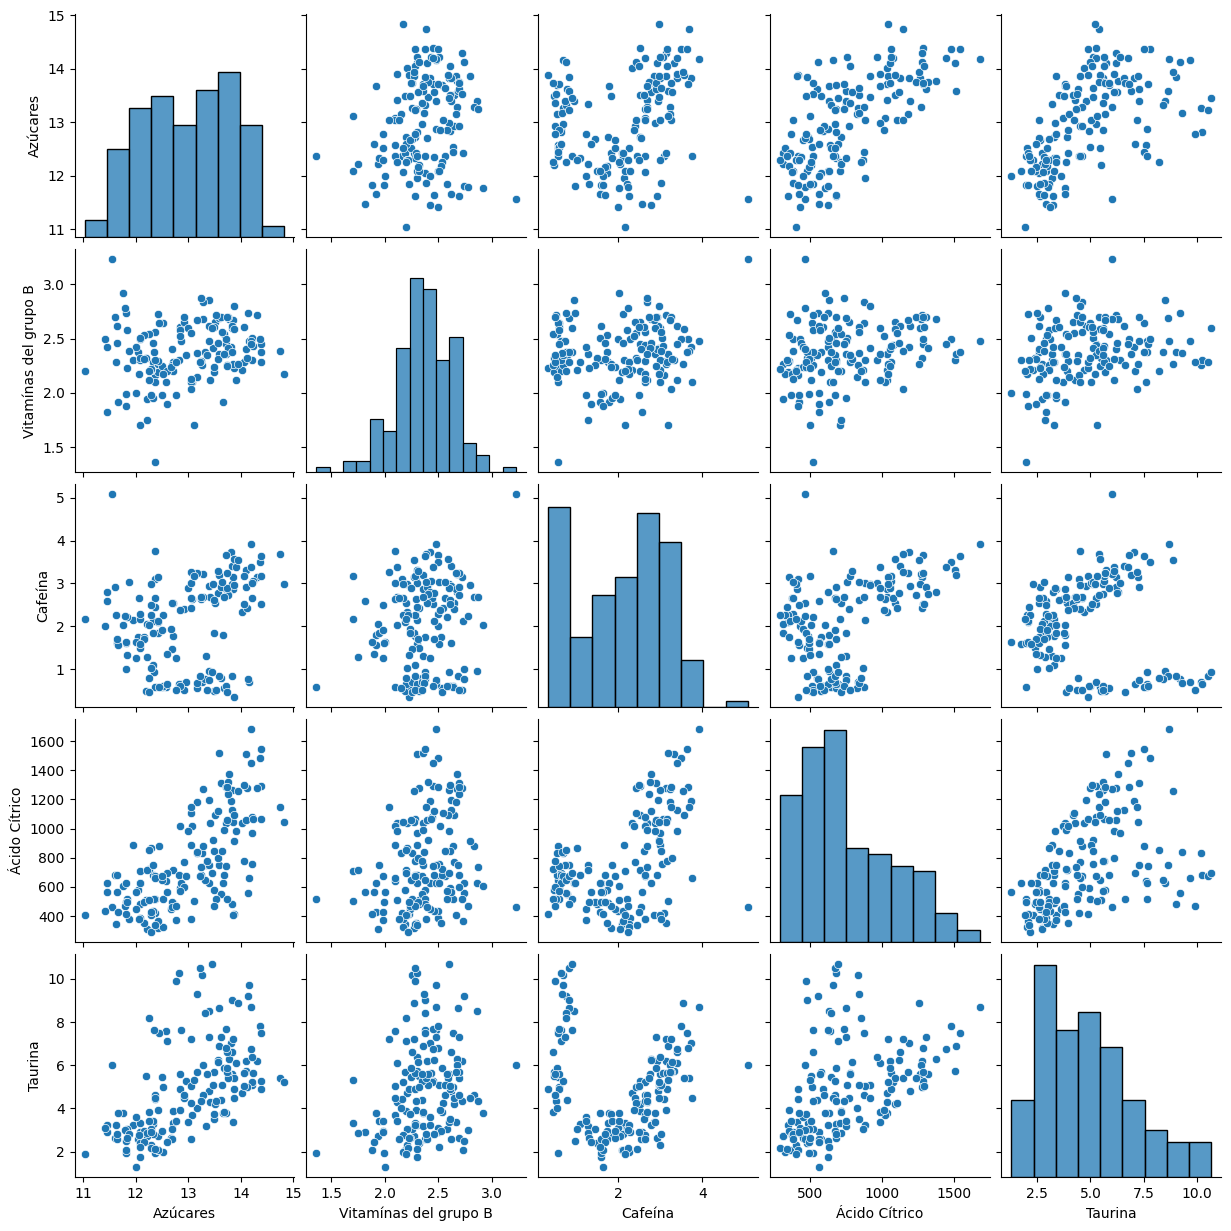

In [11]:
sns.pairplot(train_set)

Me parecen todas interesantes, me voy a quedar con ellas

In [14]:
features_num = train_set.columns.to_list()
print(len(features_num))

5


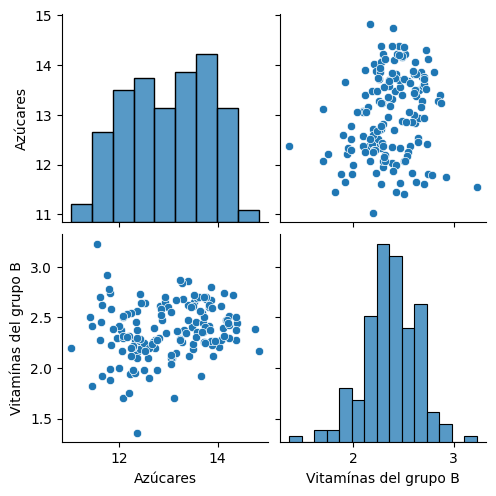

In [18]:
sns.pairplot(train_set[features_num[0:2]])

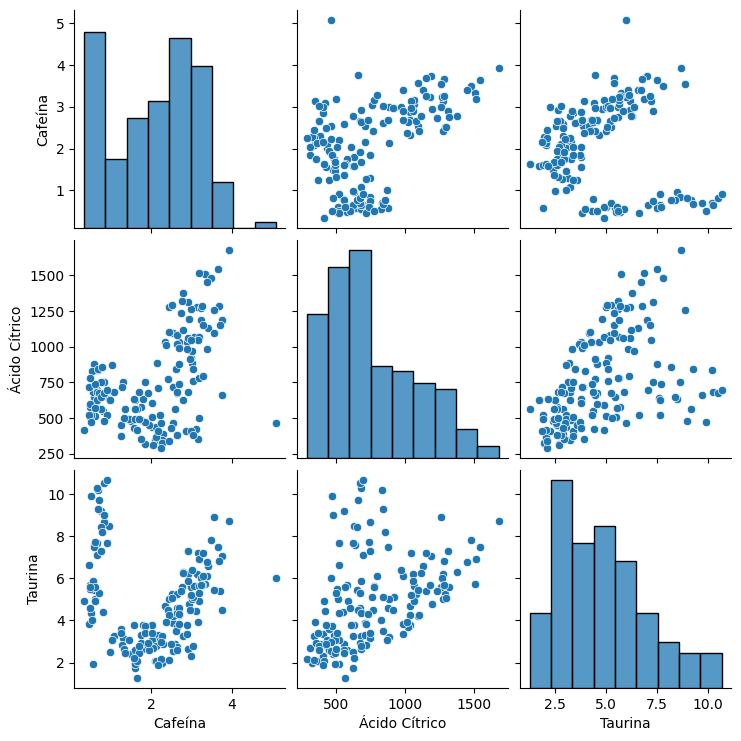

In [19]:
sns.pairplot(train_set[features_num[2:5]])

Lo puse de dos en dos como en el ejercicio, pero se ve bien completo ya que son pocas filas

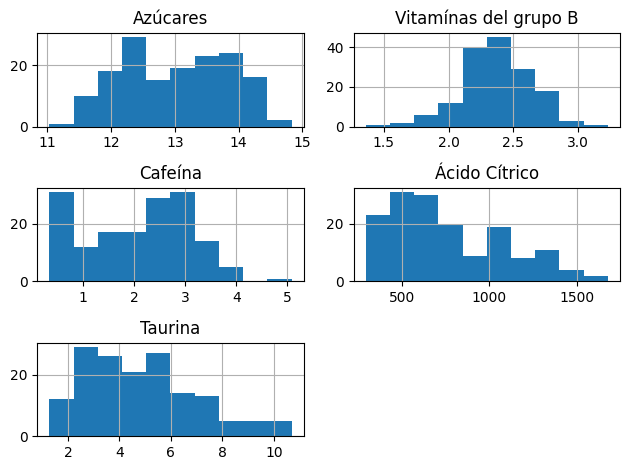

In [8]:
df.hist()
plt.tight_layout()

In [21]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='b'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=15, linewidths=20,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Text(0, 0.5, '$X_2$')

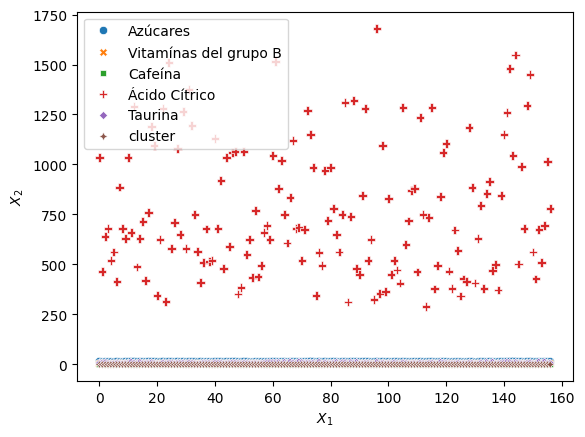

In [60]:
from sklearn.cluster import DBSCAN # Siempre, por ahora, tirando de sklearn
from sklearn.datasets import make_moons
sns.scatterplot(df)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

In [58]:
dbscan = DBSCAN(eps=50,
                min_samples=5)
dbscan.fit(df)

DBSCAN(eps=50)

In [59]:
# El algoritmo
print(dbscan)

# Todos los datos etiquetados
print(len(dbscan.labels_))

# Los 10 primeros labels
print(dbscan.labels_[:10])

# Cuantos clusters ha montado
print(np.unique(dbscan.labels_))

DBSCAN(eps=50)
157
[0 1 1 1 1 1 1 1 1 1]
[-1  0  1]


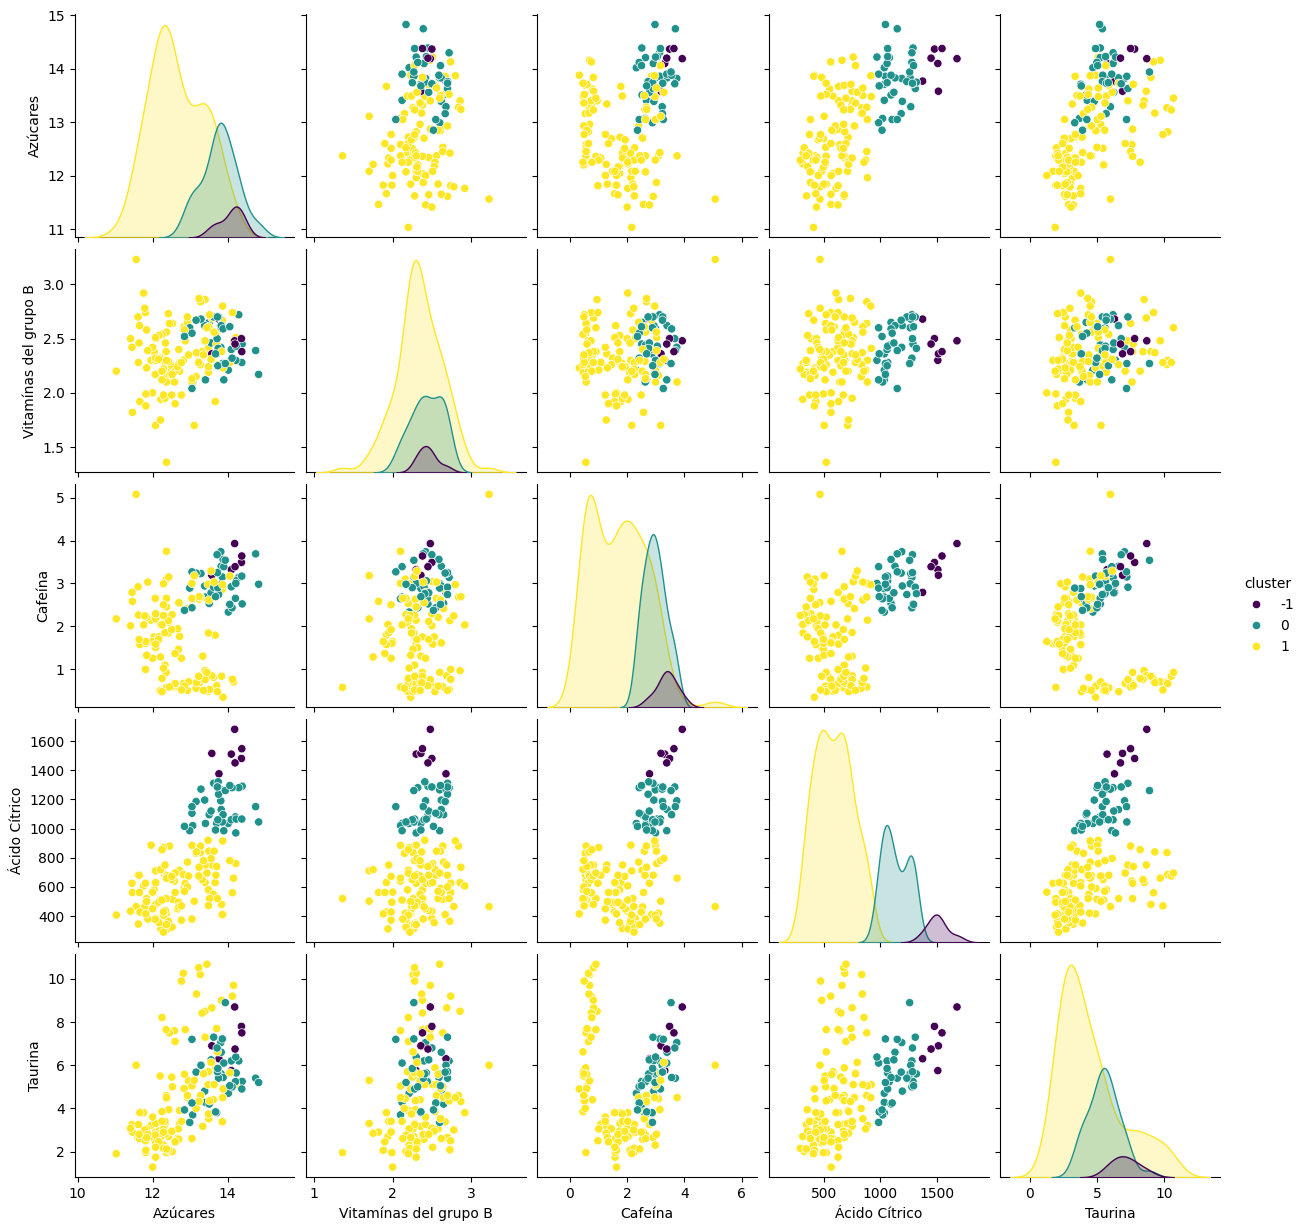

In [63]:
#voyu a ajustar parametros
df['cluster'] = dbscan.labels_

sns.pairplot(df, hue='cluster', palette='viridis')
plt.show()

In [64]:
# Aumentemos epsilon para que tenga mayor rango y se formen menos clusters
dbscan2 = DBSCAN(eps=50)
dbscan2.fit(df)

DBSCAN(eps=50)

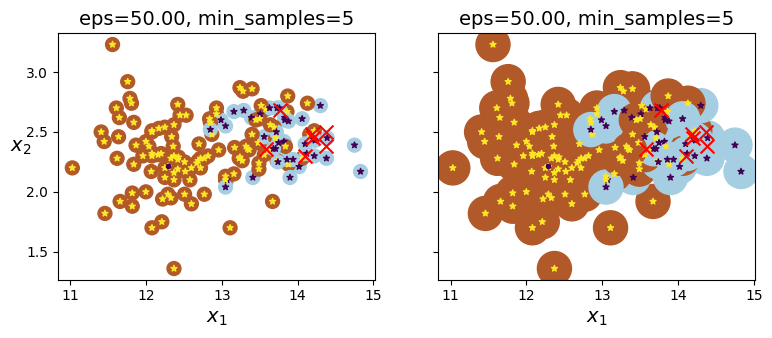

In [67]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = X.iloc[dbscan.core_sample_indices_]
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores.iloc[:, 0], cores.iloc[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores.iloc[:, 0], cores.iloc[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies.iloc[:, 0], anomalies.iloc[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores.iloc[:, 0], non_cores.iloc[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, df, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, df, size=600, show_ylabels=False)

plt.show()


In [73]:
# Aumentemos epsilon para que tenga mayor rango y se formen menos clusters
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(df)

DBSCAN(eps=0.2)

In [75]:
# Cuantos core_sample_indices_
print(len(dbscan.core_sample_indices_))

# Los indices de los 10 primeros core_sample(10 primeros elementos)
print(dbscan.core_sample_indices_[:10])

# La posicion (coordenadas) de los 5 primeros core_sample
print(dbscan.components_[:5])

149
[0 1 2 3 4 5 6 7 8 9]
[[ 1.402e+01  2.210e+00  2.330e+00  1.035e+03  4.700e+00 -1.000e+00]
 [ 1.156e+01  3.230e+00  5.080e+00  4.650e+02  6.000e+00 -1.000e+00]
 [ 1.258e+01  2.100e+00  5.800e-01  6.400e+02  7.600e+00 -1.000e+00]
 [ 1.233e+01  2.280e+00  1.090e+00  6.800e+02  3.270e+00 -1.000e+00]
 [ 1.237e+01  1.360e+00  5.700e-01  5.200e+02  1.950e+00 -1.000e+00]]


In [81]:
print("Shapes:")
print("dbscan2.components_:", dbscan2.components_.shape)
print("dbscan2.labels_[dbscan2.core_sample_indices_]:", dbscan2.labels_[dbscan2.core_sample_indices_].shape)

Shapes:
dbscan2.components_: (0, 6)
dbscan2.labels_[dbscan2.core_sample_indices_]: (0,)


In [82]:
if dbscan2.components_.shape[0] > 0 and dbscan2.labels_[dbscan2.core_sample_indices_].shape[0] > 0:
    knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])
    # Resto del código después del ajuste del modelo...
else:
    print("No hay muestras para ajustar el modelo.")


No hay muestras para ajustar el modelo.


In [83]:
from sklearn.neighbors import KNeighborsClassifier# no me deja ajustarlo, no se en que fallo
#components, son las features de las distancias core
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_]) # Fijate que se entrena con las instancias core, no con todas las instancias (aunque podríamos hacerlo con todas)
#se hace un fit a los componentes de dbscan 

ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by KNeighborsClassifier.

No me sale el dbscan

In [86]:
df.columns

Index(['Azúcares', 'Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico',
       'Taurina', 'cluster'],
      dtype='object')

<Axes: xlabel='Azúcares', ylabel='Vitamínas del grupo B'>

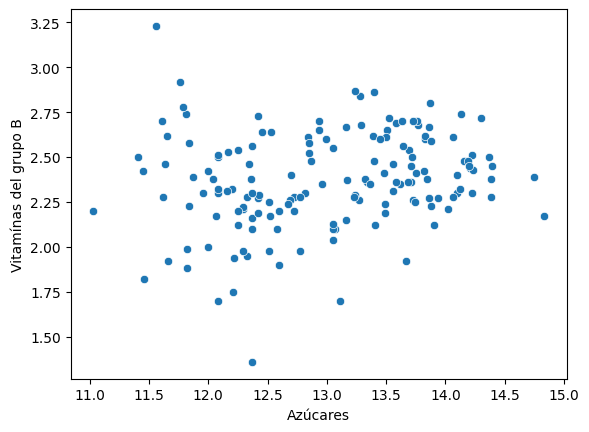

In [90]:
sns.scatterplot(x=df['Azúcares'],
                y=df['Vitamínas del grupo B'])

<Axes: xlabel='Cafeína', ylabel='Ácido Cítrico'>

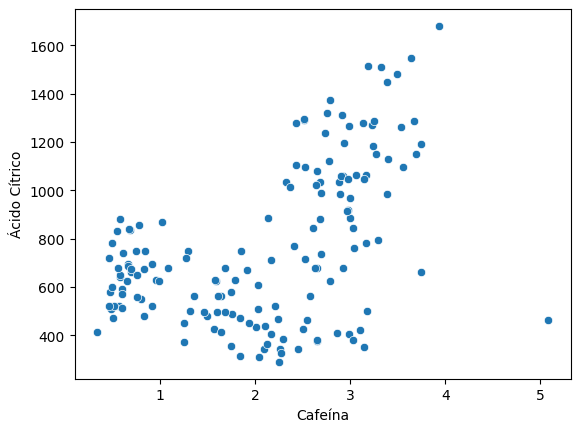

In [93]:
sns.scatterplot(x=df['Cafeína'],
                y=df['Ácido Cítrico'])

<Axes: xlabel='Taurina', ylabel='Cafeína'>

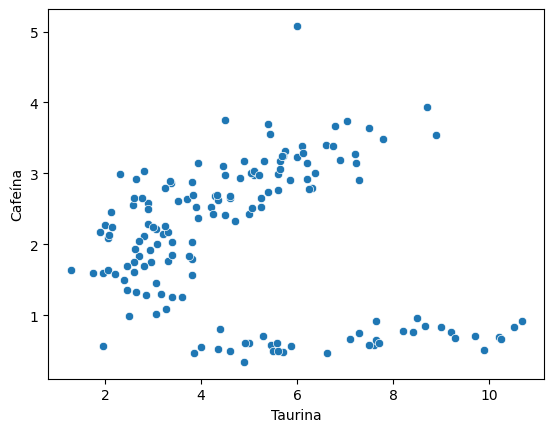

In [100]:
sns.scatterplot(x=df['Taurina'],
                y=df['Cafeína'])
                

KeyError: "None of [Index(['Azúcares (k$)', 'Cafeína (1-100)'], dtype='object')] are in the [columns]"

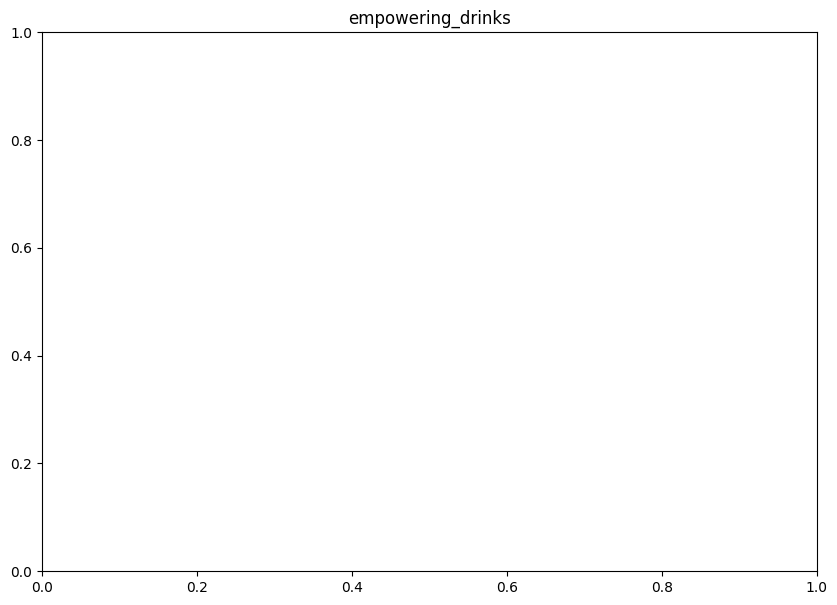

In [105]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("empowering_drinks")

selected_data = df[["Azúcares (k$)","Cafeína (1-100)"]]
clusters = shc.linkage(selected_data, 
            method='ward', # Este hiperparámetro y el siguiente tienen que ver con la distancia entre clústeres y los veremos un poco más adelante
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.